# Lab Part 4
# Neural Network Model Template

This file contains boilerplate for creating a neural network. Designing a neural network is quite difficult and requires a lot of time to set up data processing pipelines and image processing. As well as making sure that the tensors and datasets are in the correct formats. This file contains all that you need to make your very own neural network.

In [2]:
# Config Parameters for the model
# Set the batch size here
# increase for systems with more memory, 32 should be enough for most systems
BATCH_SIZE = 32

## Part 1: Unpack our data
All we do is install 7zip and then use pyunpack to extract the files. This saves datasets to /notebooks which is a directory on Paperspace Gradient that is acceptable by python.

In [3]:
# 本地环境数据加载
import zipfile
import os

# dataset file name
data_file = "data_0"  # 更改为您的数据集文件名

# 本地数据文件路径 - 修改为您的实际路径
local_zip_path = "D:\大学\2025.7-9暑假\machine-learning-practice-homework\data_0.zip"

# 检查文件是否存在
if os.path.exists(local_zip_path):
    print(f"找到数据文件: {local_zip_path}")
    
    # 解压文件
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    
    data_dir = './' + data_file + '/'
    train_dir = data_dir + 'train/'
    test_dir = data_dir + 'test/'
    
    print(f"数据已解压到: {data_dir}")
else:
    print(f"错误: 找不到数据文件 {local_zip_path}")
    print("请确保数据文件存在或修改路径")
    
    # 如果没有数据文件，使用示例路径
    data_dir = './data_0/'
    train_dir = data_dir + 'train/'
    test_dir = data_dir + 'test/'

错误: 找不到数据文件 D:\大学5.7-9暑假\machine-learning-practice-homework\data_0.zip
请确保数据文件存在或修改路径


## Part 3: Loading in the data
### Dealing with images
Our image files that we are using for training are pretty large. Your computer may crash if we loaded them all at once so instead we will just store where the images are stored. Later you will see how we can automatically load these files when we run our code. One thing to note is that each image file is named (somenumber).jpg that number is the number of milliseconds since 1 January 1970 (Unix Time) when the file was recorded. This means that we will never have any overlapping files. Unfortunately this does mean we will have to sort the times from smallest to largest to make sure that they correspond with the steering angles which are recorded sequentially.

### Dealing with steering angles
We store our steering values as a csv (comma separated values) file. Python has a built in csv module so we can easily use it to load in all the steering values into a list. These don't take up much ram so it doesn't matter if we load them all in at once. They're just numbers after all.

### Making sure the files line up
Since we sort our images, and the csv file is read in line by line the files will line up with their correct steering angles. It looks something like this. If we mess this up then the data being fed into your network would be totally incoherent. Garbage in Garbage out.

train_img =   | image 1    | image 2    | image 3    | image 4    | image 5    |...

train_steer = | steering 1 | steering 2 | steering 3 | steering 4 | steering 5 |...

In [4]:
import csv
import os
# lets make a function that loads the images and labels
def load_data(directory):
    image__paths = []
    for file in os.listdir(directory): # for each file in the directory
        if file.endswith(".png"): # if the file is an image
            image__paths.append(directory + file) # add the image path to the list
    print(image__paths)
    # now our files are in the train list we need to sort them from smallest file name to largest. The file name is the exact time the image was taken.
    image__paths.sort(key=lambda x: int(x.split('/')[-1][:-4].split('_')[0][:])) # the lambda function returns the numbers in the file name
    print(image__paths)
    # now we get the steering angles
    steering_angles = [] # create a list to store the steering angles
    for angle in image__paths: # for each row in the csv file
        steering_angles.append(float(angle.split('/')[-1][:-4].split('_')[-1].replace('-','.'))) # add the steering angle to the list
    print(steering_angles)
    return image__paths, steering_angles # return the image paths and steering angles

# We call our load data function to get the image paths and steering angles
train_img, train_steer = load_data(train_dir) # load the training data
test_img, test_steer = load_data(test_dir) # load the test data





['./data_0/train/0_103-686.png', './data_0/train/1000_62-679.png', './data_0/train/1001_55-908.png', './data_0/train/1002_49-717.png', './data_0/train/1003_45-007.png', './data_0/train/1004_41-943.png', './data_0/train/1005_40-449.png', './data_0/train/1006_40-273.png', './data_0/train/1007_41-066.png', './data_0/train/1008_42-614.png', './data_0/train/1009_44-693.png', './data_0/train/100_71-842.png', './data_0/train/1010_46-985.png', './data_0/train/1011_49-561.png', './data_0/train/1012_52-022.png', './data_0/train/1013_54-538.png', './data_0/train/1014_56-83.png', './data_0/train/1015_59-081.png', './data_0/train/1016_61-162.png', './data_0/train/1017_63-144.png', './data_0/train/1018_64-937.png', './data_0/train/1019_66-598.png', './data_0/train/101_71-524.png', './data_0/train/1020_68-18.png', './data_0/train/1021_69-577.png', './data_0/train/1022_70-889.png', './data_0/train/1023_72-059.png', './data_0/train/1024_73-152.png', './data_0/train/1025_74-141.png', './data_0/train/102

## Part 4: Loading in the images

The below code is outside the scope of this course but a brief explanation is provided nevertheless.

### Dataset Creation
The dataset creation involves the creation of what is known as a dataset pipeline. All this is, is a sequence of transformations applied one after the other that manipulate the data in different ways.
1. from_tensor_slices. We load in the images and the steering angles into the dataset
2. repeat. Simply loop the dataset for infinity when we get to the end. This is done to make sure our network never runs out of data. For instance we train on batches of 32 if we had 52 images we would run out of data.
3. shuffle. Self explanatory makes sure we don't feed network ordered data as this can cause weird issues. Note we don't need to do this with our validation data so we might as well save the unnecessary operation by excluding shuffle.
4. batch. Tell the dataset that when we fetch a item from it is should return a number of items. This is more efficient as you almost certainly have enough RAM to handle more than 1 image.
5. Prefetch. Tell the dataset that when it's not doing anything it should automatically be loading data into RAM in the background. This results in huge performance increases as when we're training we don't have to sit around waiting for the dataset to load the images.




In [5]:
# 使用国内镜像源安装 OpenCV 和其他依赖
def install_packages_with_mirror():
    """使用国内镜像源安装所需的包，并处理版本兼容性"""
    
    # 国内镜像源配置
    mirrors = [
        "https://pypi.tuna.tsinghua.edu.cn/simple/",      # 清华大学镜像
        "https://pypi.douban.com/simple/",                # 豆瓣镜像
        "https://mirrors.aliyun.com/pypi/simple/",        # 阿里云镜像
        "https://pypi.mirrors.ustc.edu.cn/simple/"        # 中科大镜像
    ]
    
    # 选择镜像源（优先使用清华镜像）
    mirror = mirrors[0]
    
    # 需要安装的包（指定兼容版本）
    packages = [
        "numpy>=1.21.0,<1.25.0",  # 指定兼容的 NumPy 版本范围
        "tensorflow>=2.10.0,<2.16.0",  # 兼容的 TensorFlow 版本
        "opencv-python",
        "tqdm", 
        "matplotlib",
        "keras>=2.10.0"
    ]
    
    print(f"🔧 使用镜像源: {mirror}")
    
    # 首先升级 pip
    try:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade", "pip"]
        subprocess.check_call(cmd)
        print("✅ pip 已升级")
    except Exception as e:
        print(f"⚠️ pip 升级失败: {e}")
    
    for package in packages:
        package_name = package.split('>=')[0].split('==')[0].split('<')[0]
        try:
            # 先检查是否已安装
            if package_name == "opencv-python":
                __import__("cv2")
            elif package_name == "tensorflow":
                __import__("tensorflow")
            else:
                __import__(package_name)
            print(f"✅ {package_name} 已安装")
        except ImportError:
            print(f"📦 正在安装 {package}...")
            try:
                # 使用镜像源安装指定版本
                cmd = [
                    sys.executable, "-m", "pip", "install", 
                    "-i", mirror,
                    "--trusted-host", mirror.split("://")[1].split("/")[0],
                    "--upgrade",
                    package
                ]
                subprocess.check_call(cmd)
                print(f"✅ {package} 安装成功")
            except Exception as e:
                print(f"❌ {package} 安装失败: {e}")
                # 尝试不指定版本重新安装
                try:
                    cmd_simple = [
                        sys.executable, "-m", "pip", "install", 
                        "-i", mirror,
                        "--trusted-host", mirror.split("://")[1].split("/")[0],
                        package_name
                    ]
                    subprocess.check_call(cmd_simple)
                    print(f"✅ {package_name} 使用简化版本安装成功")
                except Exception as e2:
                    print(f"❌ {package_name} 完全安装失败: {e2}")

# 运行安装
install_packages_with_mirror()

# 重启内核提示
print("\n🔄 建议重启 Jupyter kernel 以确保新安装的包正确加载")
print("📌 在 VS Code 中: Ctrl+Shift+P -> 'Python: Restart Kernel'")

🔧 使用镜像源: https://pypi.tuna.tsinghua.edu.cn/simple/
⚠️ pip 升级失败: name 'sys' is not defined
✅ numpy 已安装
✅ tensorflow 已安装
✅ opencv-python 已安装
✅ tqdm 已安装
✅ matplotlib 已安装
✅ keras 已安装

🔄 建议重启 Jupyter kernel 以确保新安装的包正确加载
📌 在 VS Code 中: Ctrl+Shift+P -> 'Python: Restart Kernel'


Loading training data


100%|██████████| 5000/5000 [00:01<00:00, 3615.38it/s]


Loading test data


100%|██████████| 3000/3000 [00:00<00:00, 3676.63it/s]


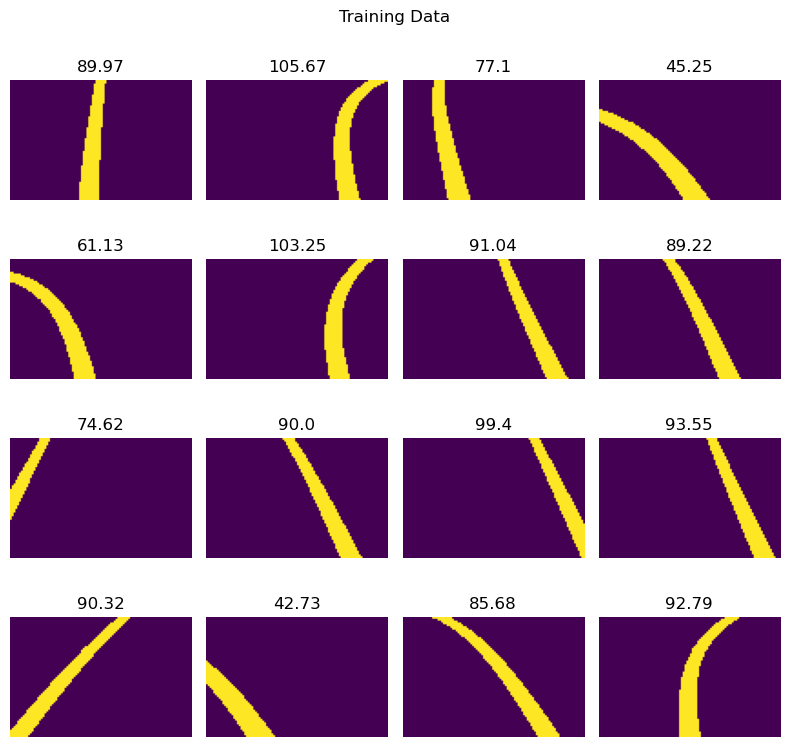

In [6]:
from matplotlib import pyplot as plt # import matplotlib for plotting
import tensorflow as tf
import cv2 as cv
#from google.colab.patches import cv2_imshow
import numpy as np
import tqdm

train_data = []
test_data = []

tqdm.tqdm.write("Loading training data")
# load the images and steering angles into numpy arrays
for path in tqdm.tqdm(train_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    train_data.append(array)

tqdm.tqdm.write("Loading test data")
# loading the testing data
for path in tqdm.tqdm(test_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    test_data.append(array)

# create a dataset from the training data and make a data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_steer)) # create a dataset from the image paths and steering angles
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=len(train_img)) # shuffle the dataset
train_ds = train_ds.batch(BATCH_SIZE) # batch the dataset
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# create a dataset from the testing data and make a data pipeline
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_steer)) # create a dataset from the image paths and steering angles
test_ds = test_ds.repeat() # repeat the dataset
test_ds = test_ds.batch(BATCH_SIZE) # batch the dataset
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
plt.tight_layout()
plt.show()

## Part 5: This is where you will create your model
try modifying the layers to try to get the lowest mse score,
This is going to require some trial and error so make sure you spend some time experimenting.

e:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 64, 98, 96)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 21, 32, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 19, 30, 48)       │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 6, 10, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2880)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       184,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,489 (896.44 KB)

 Trainable params: 229,489 (896.44 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 178.5637 - val_loss: 48.1538
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 19.7709 - val_loss: 32.2499
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 14.2481 - val_loss: 22.2974
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 11.0077 - val_loss: 22.2577
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 18.1653 - val_loss: 19.5982
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 18.0781 - val_loss: 21.6801
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 9.6778 - val_loss: 10.7711
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 5.6012 - val_loss: 11.5133
Epoch 9/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 5.5675 - val_loss: 12.8765
Epoch 10/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 6.3327 - val_loss: 8.1989
Epoch 11/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 5.3654 - val_loss: 7.0314
Epoch 12/15
156/156 

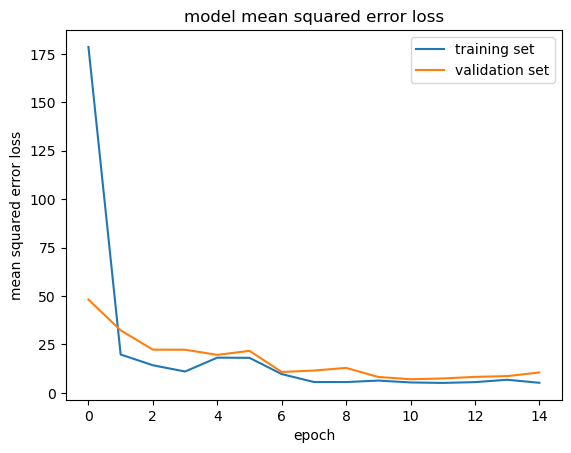

In [7]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model. You shouldn't need to change this.
model.add(InputLayer(input_shape=(66, 100, 1), batch_size=BATCH_SIZE))

# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also

# in this lab you also have access to the Conv2D layer and MaxPool2D layer. Try modifying these to see how they affect the model.
model.add(Conv2D(96, (3, 3), activation='relu'))  # conv layer -1 96 filters size 3x3
model.add(MaxPool2D(pool_size=(3, 3)))  # pooling layer size 3x3
model.add(Conv2D(48, (3, 3), activation='relu'))  # conv layer-2 with 48 filters size 3x3
model.add(MaxPool2D(pool_size=(3, 3)))  # pooling layer size

model.add(Flatten())  # flatten layer
model.add(Dense(64, activation='relu'))  # hidden dense layer with 64 units
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)  # try changing the learning rate to see how it affects the model
model.compile(optimizer=optimizer, loss='mse')  # we will keep track of the mean squared error

print(model.summary())  # print a summary of the model

# Train the model without EarlyStopping
epoch = 15
hist = model.fit(train_ds,
                 steps_per_epoch=len(train_img) // BATCH_SIZE,
                 validation_data=test_ds,
                 validation_steps=len(test_img) // BATCH_SIZE,
                 epochs=epoch)  # EarlyStopping removed

# let's plot the model's history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.plot(np.log(hist.history['loss']))       # log scale
# plt.plot(np.log(hist.history['val_loss']))   # log scale
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


Have a look at the graph generated below. With this you can get an idea of whether your model is training well. You should want to see both lines trend downwards.

## Part 6: Test the model
We'll now output 16 images with the predicted steering angles along with the actual steering angles

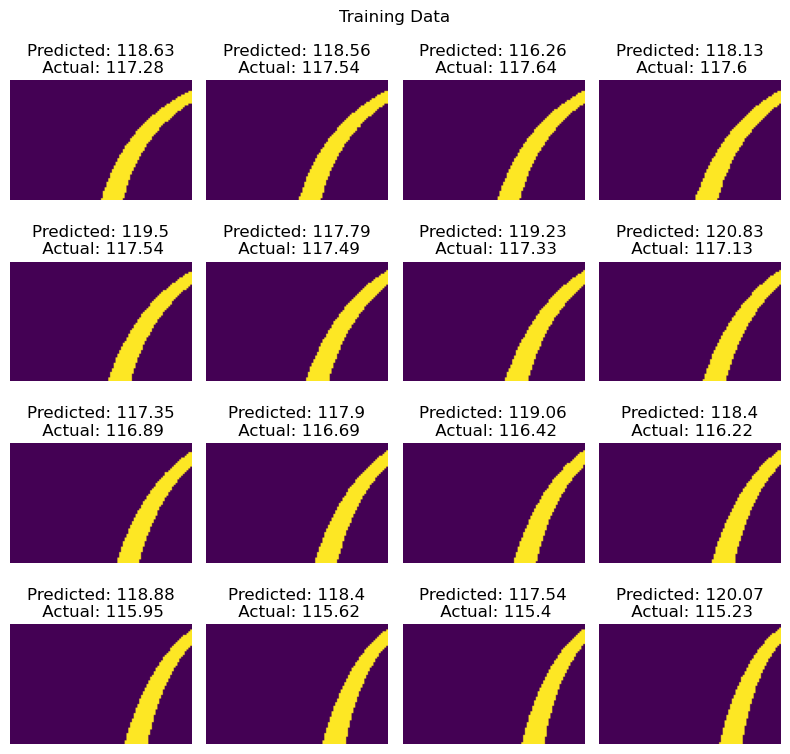

In [8]:
# output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
    predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
    axs[i//4, i%4].set_title("Predicted: " + str(np.round(predicted[0][0].numpy(), 2)) + "\n Actual: " + str(round(steer[i].numpy(), 2)))
plt.tight_layout()
plt.show()

## Part 7: export your model
Once you are happy with your model you can export it by running the code below.
This will save your model as model.h5 and model.onnx.

The ".h5" model is used for the physical PiCar and the ".onnx" model is used for the PiCar Simulator. You can change this to be more descriptive. I also recommend saving multiple models with different training settings so you have a couple to experiment with.

In [9]:
import subprocess
import sys

def install_onnx_packages_fixed():
    """使用镜像源安装 ONNX 包 - 修复版本"""
    
    mirror = "https://pypi.tuna.tsinghua.edu.cn/simple/"
    host = "pypi.tuna.tsinghua.edu.cn"
    
    # 尝试安装预编译的 wheel 包
    packages = [
        "onnx>=1.12.0",  # 指定版本范围
        "tf2onnx>=1.13.0"
    ]
    
    for package in packages:
        package_name = package.split('>=')[0].split('==')[0]
        try:
            # 检查是否已安装
            if package_name == "tf2onnx":
                import tf2onnx
                print(f"✅ {package_name} 已安装")
            else:
                import onnx
                print(f"✅ {package_name} 已安装")
        except ImportError:
            print(f"📦 正在安装 {package}...")
            try:
                # 优先使用预编译的 wheel
                cmd = [
                    sys.executable, "-m", "pip", "install",
                    "-i", mirror,
                    "--trusted-host", host,
                    "--only-binary=all",  # 只使用预编译包
                    "--upgrade",
                    package
                ]
                subprocess.check_call(cmd)
                print(f"✅ {package} 安装成功")
            except Exception as e:
                print(f"❌ 预编译包安装失败: {e}")
                # 尝试使用 conda-forge
                try:
                    print(f"🔄 尝试使用 conda 安装 {package_name}...")
                    conda_cmd = ["conda", "install", "-c", "conda-forge", package_name, "-y"]
                    subprocess.check_call(conda_cmd)
                    print(f"✅ {package_name} 通过 conda 安装成功")
                except Exception as e2:
                    print(f"❌ conda 安装也失败: {e2}")

install_onnx_packages_fixed()

✅ onnx 已安装
✅ tf2onnx 已安装


In [12]:
import tensorflow as tf
import tf2onnx
import onnx

model_name = "model"  # 更改为更具描述性的名称

# 保存 Keras 格式
model.save(model_name + '.keras')
model.save(model_name + ".h5")

# 修复的 ONNX 转换方法
try:
    # 方法 1: 使用 saved_model 路径转换（推荐）
    print("尝试方法 1: 通过 saved_model 转换...")
    
    # 先保存为 saved_model 格式
    temp_model_path = "./temp_saved_model"
    model.save(temp_model_path, save_format='tf')
    
    # 从 saved_model 转换到 ONNX
    onnx_model, _ = tf2onnx.convert.from_saved_model(
        temp_model_path,
        opset=13,
        output_path=model_name + ".onnx"
    )
    print("✅ 方法 1 成功")

except Exception as e1:
    print(f"方法 1 失败: {e1}")
    try:
        # 方法 2: 使用具体函数转换
        print("尝试方法 2: 使用具体函数转换...")
        
        # 创建具体函数
        full_model = tf.function(lambda x: model(x))
        concrete_func = full_model.get_concrete_function(
            tf.TensorSpec([None, 66, 100, 1], tf.float32, name='input')
        )
        
        # 转换到 ONNX
        onnx_model, _ = tf2onnx.convert.from_function(
            concrete_func,
            opset=13,
            output_path=model_name + ".onnx"
        )
        print("✅ 方法 2 成功")
        
    except Exception as e2:
        print(f"方法 2 也失败: {e2}")
        try:
            # 方法 3: 直接使用 from_keras（兼容版本）
            print("尝试方法 3: 直接 Keras 转换...")
            
            # 不指定 input_signature，让 tf2onnx 自动推断
            onnx_model, _ = tf2onnx.convert.from_keras(
                model,
                opset=13,
                output_path=model_name + ".onnx"
            )
            print("✅ 方法 3 成功")
            
        except Exception as e3:
            print(f"所有方法都失败了:")
            print(f"错误 1: {e1}")
            print(f"错误 2: {e2}")
            print(f"错误 3: {e3}")
            print("建议更新 tf2onnx 版本或使用其他转换工具")

print(f"模型已保存为:")
print(f"- {model_name}.keras (Keras 格式)")
print(f"- {model_name}.h5 (HDF5 格式)")
print(f"- {model_name}.onnx (ONNX 格式，如果转换成功)")

尝试方法 1: 通过 saved_model 转换...
方法 1 失败: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf
尝试方法 2: 使用具体函数转换...
方法 2 也失败: from_function requires input_signature
尝试方法 3: 直接 Keras 转换...
所有方法都失败了:
错误 1: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf
错误 2: from_function requires input_signature
错误 3: 'Sequential' object has no attribute '_get_save_spec'
建议更新 tf2onnx 版本或使用其他转换工具
模型已保存为:
- model.keras (Keras 格式)
- model.h5 (HDF5 格式)
- model.onnx (ONNX 格式，如果转换成功)
